# Modeling Sensor Readings
I have constructed 
* `Visualize_Senosr_Reading.py`
* `humidityTempSensor.ino`
* `arduino.yml`

to gather and record humidity sensor readings. In this notebook, I will fit the experimental data to a model I designed using a **Linear First Order Differential Equation**.

## Model description
I modeled the rise of humidity using $$\frac{dn_v}{dt} + ln_v = E , n_v(t_0) = n_{v0}$$ whose solution yielded the equation $$n_v(t) = \frac{n_{v0} + \frac{E}{l}(e^{lt}-1)}{e^{lt}}, \lim_{t\to\infty} n_v(t) = \frac{E}{l}, \lim_{t\to 0} n_v(t) = n_{v0}.$$

In [1]:
# live_plot_sensor.py
import time
from datetime import date
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from math import e
# https://realpython.com/linear-regression-in-python/
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# https://education.molssi.org/python-data-analysis/03-data-fitting/index.html
from scipy.optimize import curve_fit


def rollingFun(data, windowSize, fun=np.mean):
    rollingAverage = []
    data = np.array(data)
    for i in range(len(data)):
        windowStart = np.maximum(0,i-windowSize)
        windowEnd = np.minimum(len(data)-1,i+windowSize)
        rollingAverage.append(fun(data[windowStart:windowEnd]))
    return(rollingAverage)

In [2]:
df = pd.read_csv("temp_humidity_11_16_22_airtight.txt")

In [3]:
x = np.array(range(1,len(df['Humidity'])+1))
x = x.reshape(-1,1)
yH = df['Humidity']
yT = rollingFun(df['Temp'], 200)

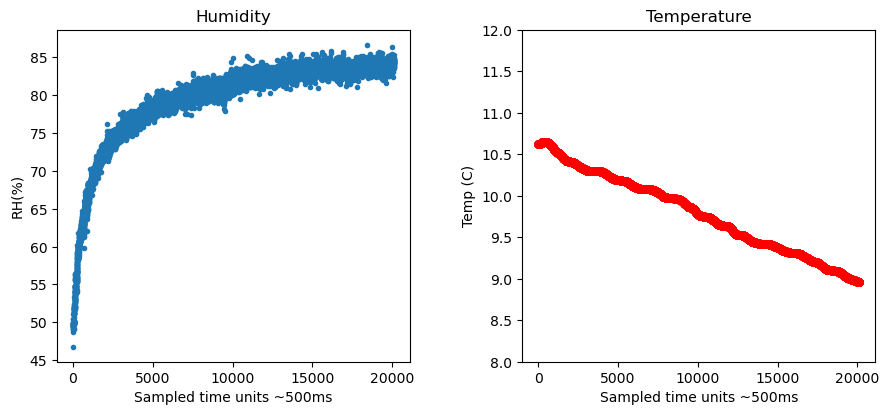

In [4]:
fig, ax = plt.subplots(1,2, figsize=[10,5])
fig.tight_layout(pad=5.0)
ax[0].title.set_text("Humidity")
ax[0].set_ylabel('RH(%)')
ax[0].plot(x,yH, linewidth=0, marker='.')
ax[1].title.set_text("Temperature")
ax[1].set_ylabel('Temp (C)')
ax[1].set_ylim([8,12])
ax[1].scatter(x,yT, linewidth=0, c='red')

for axs in ax:
    axs.set_xlabel("Sampled time units ~500ms")

# Fitting the data to my model
Following the tutorial found here https://education.molssi.org/python-data-analysis/03-data-fitting/index.html
, I will now fit my model to the data using the following steps. **Note** The `curve_fit` function may not like very big numbers, or it may require initial guesses to converge. Try either giving it guesses or divide your input x's to make them smaller.
1. Define my equation
1. Define my data
1. fit the curve
1. plot the fit and the original data

## Defining my 1st order model

In [5]:
def nv(t, nv0, E, l):
    return((nv0 + E/l * (e**(l*t)-1))/(e**(l*t)))

## Defining my data

In [6]:
df = pd.read_csv("temp_humidity_11_16_22_airtight.txt")
df['Time'] = pd.to_datetime(df['Time'])
x = np.array(range(1,(len(df['Humidity'])+1)))/2/60
yH = df['Humidity']

## Fitting the curve

In [7]:
parameters, covariance = curve_fit(nv, x, yH)
SE = np.sqrt(np.diag(covariance))

C:\Users\mattk\AppData\Local\Temp\ipykernel_2456\2839973397.py:2: RuntimeWarning: divide by zero encountered in divide
  return((nv0 + E/l * (e**(l*t)-1))/(e**(l*t)))
C:\Users\mattk\AppData\Local\Temp\ipykernel_2456\2839973397.py:2: RuntimeWarning: overflow encountered in divide
  return((nv0 + E/l * (e**(l*t)-1))/(e**(l*t)))


In [8]:
fit_nv0 = parameters[0]; SE_nv0 = SE[0]
fit_E = parameters[1]; SE_E = SE[1]
fit_l = parameters[2]; SE_l = SE[2]
fit_yH = nv(x, fit_nv0, fit_E, fit_l)
print(f'nv0: {fit_nv0} -- SE: {SE_nv0}\nE: {fit_E} -- SE: {SE_E}\nl: {fit_l} -- SE: {SE_l}')

nv0: 57.903577880815575 -- SE: 0.05120779532595725
E: 3.6233398766381346 -- SE: 0.012370038389466907
l: 0.04367059312177762 -- SE: 0.0001532870188058594


Saturation occurs at 82.96978853789027


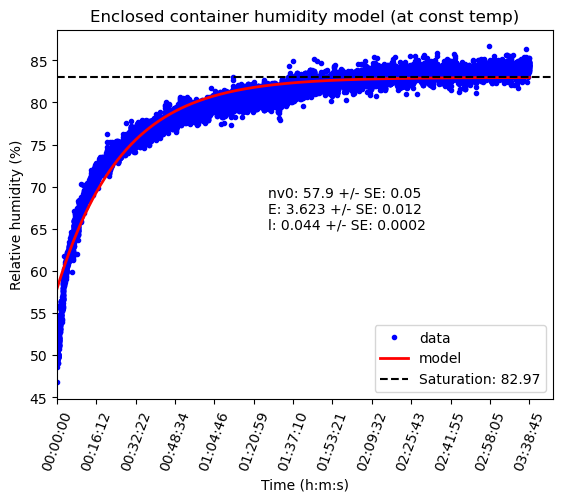

In [9]:
plt.title("Enclosed container humidity model (at const temp)")
plt.plot(x,yH, marker='.', linewidth=0, c='blue', label='data')
plt.plot(x,fit_yH, linewidth=2, c='red', label='model')
plt.axhline(fit_E/fit_l, c='black', label=f'Saturation: {round(fit_E/fit_l,2)}', linestyle='--')
plt.xlim(left=0)
plt.legend(loc='lower right')
plt.ylabel("Relative humidity (%)")
plt.xlabel('Time (h:m:s)')
# np.linspace(0,max(x), 10)
plot_labels = (df.Time - df.Time[0]).astype(str).str.replace('0 days ', '')# np.round_(x,2) # df.Time.dt.time #
plt.xticks([x[i] for i in range(0,len(x),len(x)//12)], labels=plot_labels[range(0,len(x),len(x)//12)], rotation=70)
plt.text(x=75,y=65,s=f'nv0: {round(fit_nv0,2)} +/- SE: {round(SE_nv0,2)}\nE: {round(fit_E,3)} +/- SE: {round(SE_E,3)}\nl: {round(fit_l,3)} +/- SE: {round(SE_l,4)}')
print(f'Saturation occurs at {fit_E/fit_l}')
plt.show()

# Conclusions
For future work, I need to find a way to do math and fit models for datetime objects. That way my E and l could have directly interpretable units of something/second. Other than that, I would say my two parameter model works pretty good. It doesn't capture the interesting quick rise at the very beginning of the curve, or the continous upward trajectory, but it does seem to give a fairly good approximation. 

Maybe the temperature could be incorporated because while I say constant temp, it was actually going down ever so slightly which can drastically affect the data. Additionally, my model assumes perfect isolation, while my system had a small pore through which air could escape. Lastly, my model assumes that evaporation can only happen at the interface of the liquid I add to the system. Intuitively that isn't quite correct because condensation happens everywhere, and the entire container essentially becomes a sight of evaporation. This value changes with time.

Anywho, it works alright so I won't mess around with it more.